# MD for Experiment Validation

The YAML input file can be found at [input_file](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/examples/UNP/input_files/ucp_N10k.yaml) and this notebook at [notebook](https://raw.githubusercontent.com/murillo-group/sarkas/master/docs/examples/UNP/UCP_Experiment_Validation.ipynb).

## Ultracold Neutral Plasmas
Sarkas has been developed with the experimental plasma physics community in mind. An example of strongly coupled plasmas are [**Ultracold Neutral Plasmas**](https://science.sciencemag.org/content/316/5825/705). In these systems a cloud of $N \sim 10^6 - 10^9$ neutral atoms is trapped and cooled to ~mK temperatures. The cloud has a spherical Gaussian density distribution with peak densities in the range $\sim 10^{15}-10^{16}\, \textrm{N/cc}$  with a standard deviation ranging from hundreds of $\mu$m to few mm. A portion of the atoms is then ionized by shining a laser, with the correct wavelength, onto the cloud. The energy from the laser is deposited on the electrons which now have enough energy to escape the the atoms, thus, leaving behind positively charged ions.

UNPs are an optimal experimental setup to study strongly coupled plasmas since the charge number, the number density, and the temperature of the plasma are well defined and controllable. This is in contrast to other experiments in which some parameters are not well known and require simulations and models to be extracted from experimental data. 

UNPs are considered strongly coupled plasmas because of their low kinetic energy. The strong coupling parameter is defined as

$$ \Gamma = \frac{(Ze)^2}{4\pi \varepsilon_0 a_{\rm ws}} \frac{1}{k_B T} $$

where $Z$ is the charge number of the ions, $T$ their temperature, and $a = (3/ 4\pi n)^{1/3}$ is the Wigner-Seitz radius defined by the number density $n$. In UNP experiments $1 < \Gamma \sim 10$.

## Disorder Induced Heating
In the laser-cooling phase of the experiment atoms are neutral. This allows them to get very close to each other and distribute randomly in space. The potential energy in this case is very low and so is the kinetic energy. 
By photoionizing the atoms we are effectively turning on the Coulomb interaction. The system now has a large potential energy which pushes the ions apart, thus the potential energy is converted into kinetic energy ($\sim k_BT$). This process is called **Disorder Induced Heating (DIH)**.

DIH is unavoidable and it is one of the biggest obstacles that prevents UNPs to reach $\Gamma > 10$. This is because the initial potential energy is what determines the final temperature and the final $\Gamma$. Large potential energies lead to large kinetic energies and low $\Gamma$. Furthermore, in an experiment the temperature evolution of the ions in the DIH phase is used to determine/validate the number density of the initial charged cloud. 

In the following example we will present a workflow to prepare and run an MD simulation and extract the DIH temperature of a UNP.

## PreProcessing

We start by importing the usual libraries and creating a path to the input file of our simulation.

In [3]:
%pylab
%matplotlib inline
import os
import pandas as pd

from sarkas.processes import PreProcess, Simulation, PostProcess

# plt.style.use('MSUstyle')
input_file = os.path.join('input_files', 'ucp_N10k.yaml')

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


We then run the ``PreProcess.run()`` method to validate our simulation parameters.

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

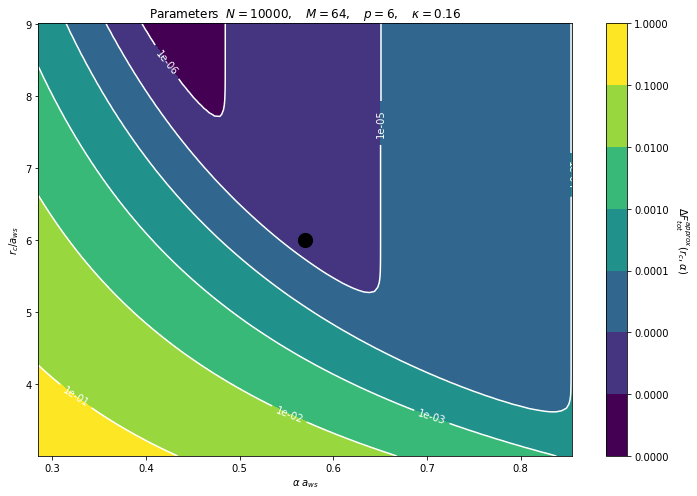

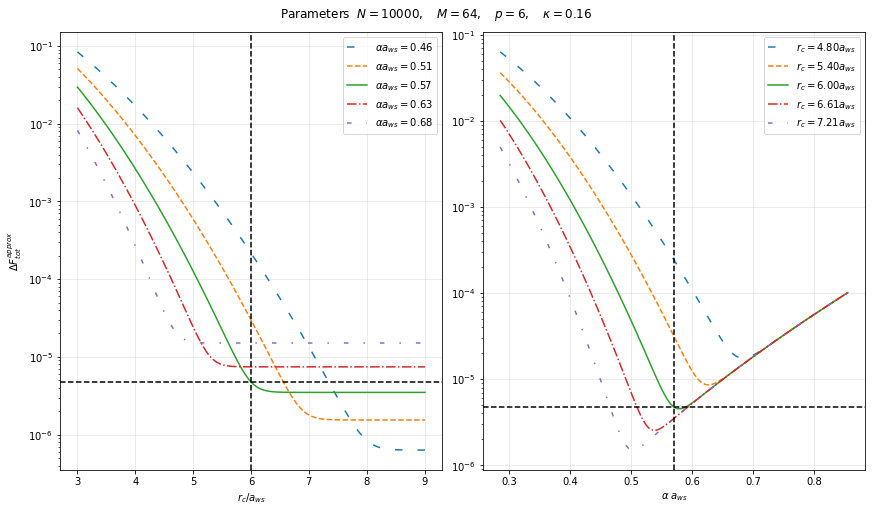

In [5]:
# Initialize the class
preproc = PreProcess(input_file)
# Setup Sarkas classes and initialize all the parameters
preproc.setup(read_yaml=True)
# Run 100 steps to calculate the total time of the simulation.
# Also show plots of the Force error to validate the PPPM parameters.
preproc.run(loops = 15, pppm_estimate = True)

## Simulation

Once the simulation parameters have been decided we can start running our simulation. Since we are dealing with a non-equilibrium simulation, in order to get some statistics we need to run multiple simulations with different initial conditions. This can be done by changing the random number seed. 

Below we show a sample code that executes three (3) MD simulation by changing only the `rand_seed` parameter and the storing directory.

In [7]:
# Define a random number generator
rg = np.random.Generator( np.random.PCG64(154245) )

# Loop over the number of independent MD runs to perform
for i in range(5):
    # Get a new seed
    seed = rg.integers(0, 15198)
    
    args = {
        "Parameters": {"rand_seed": seed}, # define a new rand_seed for each simulation
        
        "IO":   # Store all simulations' data in simulations_dir, 
                # but save the dumps in different subfolders (job_dir) 
            {
                "simulations_dir": 'UCP_DIH_N10k',
                "job_dir": "run{}".format(i),
                "verbose": True # This is so not to print to screen for every run
            },
    }
    # Run the simulation.
    sim = Simulation(input_file)
    sim.setup(read_yaml=True, other_inputs=args)
    sim.run()
    print('Run {} completed'.format(i) )

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The above code will take a long time, because we need to wait for the previous simulation to finish before starting a new one. Notice that we define the `rand_seed` parameter in each loop. This is because even though we are in the same Python process Sarkas has a default `rand_seed`. Thus, if we don't pass it we will end up with three identical simulations.

If we can afford to occupy few processors on our computer we can save time by running each simulation in a different JupyterNotebook or by running three Python scripts at the same time.

## PostProcessing

Once the simulations are done, we can start our Post Processing. In the following we will calculate the average temperature and RMS speed of each species in the mixture. Save them into a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and plot them.

In [8]:
# Initialize the storing df
Temp_vel_data = pd.DataFrame()

# No. of independent runs
runs = 5

# Loop over the runs and initialize the PostProcess
for i in range(runs):
    # This is a copy-n-paste from the code snippet above. We only change sim with postproc
    # Some lines are commented out because they are not needed. 
    
    # Get a new seed
    #seed = rg.integers(0, 1598765198)
    
    args = {
        # "Parameters": {"rand_seed": seed}, # define a new rand_seed for each simulation
        
        "IO":   # Store all simulations' data in simulations_dir, 
                # but save the dumps in different subfolders (job_dir) 
            {
                "simulations_dir": 'UCP_DIH_N10k',
                "job_dir": "run{}".format(i),
                "verbose": False  # This is so not to print to screen for every run
            },
    }
    
    postproc = PostProcess(input_file)
    postproc.setup(read_yaml = True, other_inputs=args)
        
    # Rename the Thermodynamics class for convenience
    E = postproc.therm
    # Setup its attributes
    E.setup(postproc.parameters)
    # Grab the data
    E.parse()

    # Save the time array once. Obviously this has to be the same for each run.
    if i == 0:               
        Temp_vel_data['Time'] = E.dataframe["Time"] * 1e6 # scale by microsec

    # Grab the total temperature. This is the only line needed in the case of a One-Component plasma
    Temp_vel_data['Temperature run {}'.format(i)] = E.dataframe["Temperature"]
    Temp_vel_data['Gamma run {}'.format(i)] = E.qe**2/ (E.fourpie0 * E.kB * E.a_ws * E.dataframe['Temperature']) 
    Temp_vel_data['RMS Speed run {}'.format(i)] = np.sqrt(E.kB * E.dataframe['Temperature'] / postproc.species[0].mass)

In [9]:
# Let's look at the data
Temp_vel_data.head(10)

,Time,Temperature run 0,Gamma run 0,RMS Speed run 0,Temperature run 1,Gamma run 1,RMS Speed run 1,Temperature run 2,Gamma run 2,RMS Speed run 2,Temperature run 3,Gamma run 3,RMS Speed run 3,Temperature run 4,Gamma run 4,RMS Speed run 4
0,0.000000,0.002012,2125.666966,0.434378,0.001992,2147.003605,0.432214,0.001993,2145.592909,0.432356,0.002012,2125.365953,0.434409,0.002005,2132.681082,0.433663
1,0.001510,0.009480,451.038457,0.942994,0.006151,695.103940,0.759610,0.009684,441.534608,0.953089,0.012005,356.168654,1.061177,0.003818,1120.028223,0.598413
2,0.003019,0.023328,183.297094,1.479237,0.016814,254.311940,1.255834,0.022112,193.371755,1.440188,0.021222,201.484021,1.410897,0.009713,440.236556,0.954493
3,0.004529,0.038619,110.720610,1.903274,0.029780,143.584409,1.671329,0.035211,121.435566,1.817367,0.031817,134.392363,1.727541,0.018812,227.301845,1.328355
4,0.006038,0.055068,77.648020,2.272744,0.043934,97.325658,2.030028,0.049286,86.757042,2.150123,0.044007,97.163651,2.031719,0.030301,141.114392,1.685893
5,0.007548,0.072489,58.986940,2.607580,0.059017,72.451706,2.352834,0.064403,66.393123,2.457843,0.057647,74.173778,2.325361,0.043631,98.001971,2.023011
6,0.009057,0.090750,47.117642,2.917587,0.074925,57.069344,2.651027,0.080506,53.113072,2.747989,0.072592,58.902950,2.609439,0.058446,73.159560,2.341424
7,0.010567,0.109749,38.960715,3.208501,0.091588,46.686353,2.931033,0.097502,43.854646,3.024181,0.088709,48.201556,2.884597,0.074506,57.390469,2.643600
8,0.012076,0.129409,33.041938,3.484038,0.108950,39.246472,3.196799,0.115294,37.087158,3.288546,0.105873,40.387065,3.151334,0.091630,46.664911,2.931706
9,0.013586,0.149663,28.570185,3.746788,0.126959,33.679328,3.450912,0.133790,31.959897,3.542525,0.123973,34.490527,3.410089,0.109680,38.985271,3.207490


In [10]:
# Calculate mean and std using a loop

tags = ["Temperature", "Gamma", "RMS Speed"]

for lbl in tags:
    
    # Average Temperature
    mean_tot = Temp_vel_data[ ["{} run {}".format(lbl, i) for i in range(runs) ]].mean( axis = 1)
    std_tot = Temp_vel_data[ ["{} run {}".format(lbl, i) for i in range(runs) ]].std( axis = 1)

    # Average and Standard Deviation of Total Temperature
    Temp_vel_data['Mean {}'.format(lbl)] = mean_tot
    Temp_vel_data['Std {}'.format(lbl)] = std_tot
    
# Save the data
file_path = os.path.join(postproc.io.simulations_dir,'Temp_vel_data.csv')
Temp_vel_data.to_csv(file_path, index=False, encoding='utf-8')

# Let's look at the data again but only at the last additions 
Temp_vel_data.iloc[:10, 16:]

,Mean Temperature,Std Temperature,Mean Gamma,Std Gamma,Mean RMS Speed,Std RMS Speed
0,0.002003,0.000010,2135.262103,10.502982,0.433404,0.001065
1,0.008228,0.003230,612.774776,310.408072,0.863057,0.183361
2,0.018638,0.005562,254.540273,107.372372,1.308130,0.215100
3,0.030848,0.007523,147.486958,46.334528,1.689573,0.220370
4,0.044519,0.009175,100.001752,24.395579,2.034101,0.218908
5,0.059437,0.010586,74.001504,14.678032,2.353326,0.215325
6,0.075444,0.011803,57.872514,9.665922,2.653493,0.210956
7,0.092411,0.012860,47.018748,6.782801,2.938382,0.206258
8,0.110231,0.013784,39.285509,4.987120,3.210485,0.201450
9,0.128813,0.014598,33.537042,3.800317,3.471561,0.196675


It is now time to plot and compare with experiment. For this tutorial we grabbed experimental data from 
Fig.~(2) of this [paper](http://dx.doi.org/10.1063/1.4915135). This data was obtained using [WebPlotDigitizer](https://automeris.io/WebPlotDigitizer/) and saved into the file ``paper_data.csv``.

We will plot both the temperature and the RMS speed side by side and compare with the experimental data.

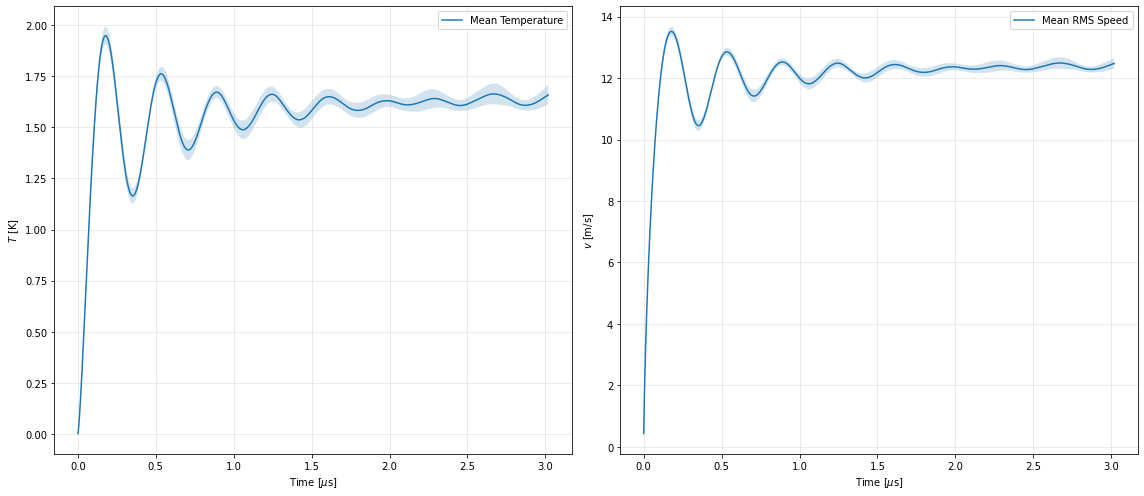

In [12]:
# Grab data from Killian 
# paper_data = np.loadtxt('paper_data.csv', delimiter=',')

# Plot Temperature and thermal speed
fig, (ax_temp, ax_rms) = plt.subplots(1,2, figsize=(16, 7))

# Plot Temperature
Temp_vel_data.plot(x = 'Time', y = 'Mean Temperature', ax = ax_temp)
# Plot std error as shaded area 
ax_temp.fill_between(
    Temp_vel_data['Time'], 
    Temp_vel_data["Mean Temperature"] - Temp_vel_data["Std Temperature"],
    Temp_vel_data["Mean Temperature"] + Temp_vel_data["Std Temperature"], 
    alpha = 0.2)
# Plot paper data
# ax_temp.scatter(paper_data[:,0], paper_data[:,1], s=100, label = 'Paper Data')
# embellish
ax_temp.grid(alpha = 0.3)
ax_temp.legend()
ax_temp.set(ylabel = r'$T$ [K]', xlabel =r'Time [$\mu$s]')

# Plot Gamma
# Temp_vel_data.plot(x = 'Time', y = 'Mean Gamma', ax = ax_gamma)
# ax_gamma.fill_between(
#     Temp_vel_data['Time'], 
#     Temp_vel_data["Mean Gamma"] - Temp_vel_data["Std Gamma"],
#     Temp_vel_data["Mean Gamma"] + Temp_vel_data["Std Gamma"], alpha = 0.2)

# ax_gamma.grid(alpha = 0.3)
# ax_gamma.set(ylabel = r'$\Gamma$', xlabel =r'Time [$\mu$s]', ylim = (0, 5))

# Plot RMS Speed
Temp_vel_data.plot(x = 'Time', y = 'Mean RMS Speed', ax = ax_rms)
# Plot std error as shaded area 
ax_rms.fill_between(
    Temp_vel_data['Time'],
    Temp_vel_data["Mean RMS Speed"] - Temp_vel_data["Std RMS Speed"],
    Temp_vel_data["Mean RMS Speed"] + Temp_vel_data["Std RMS Speed"], alpha = 0.2)

# embellish
ax_rms.grid(alpha = 0.3)
ax_rms.set( ylabel = r'$v$ [m/s]', xlabel= r'Time [$\mu$s]')

# Finishing
fig.tight_layout()
figname = os.path.join(postproc.io.simulations_dir,'Temperature_n_RMS_Plot.png')
fig.savefig(figname)


Noice! There is good agreement for the first microsecond.

### Distributions for Thermalization analysis

The next important quantity that we need are velocity distributions. Sarkas allows you to calculate these easily and automatically average of the multiple runs and over the three cartesian dimensions. 
The last two are flags that can be passed when calculating.

First we print the parameters of the velocity distributions

In [15]:
from sarkas.tools.observables import VelocityDistribution

vd = VelocityDistribution()
vd.setup(
    postproc.parameters, # We need to pass simulations parameters always 
    max_no_moment=10, # This is the maximum number of distribution moments to calculate
    multi_run_average=True, # Do we want to average over multiple runs ?
    runs = 5, # Tell me the number of runs.
    dimensional_average=True, # Do we want to average over the three directions?
    max_hermite_order = 5
)

# Let's print out some info
vd.pretty_print()



======================= Velocity Distribution ======================== 

CSV dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/VelocityDistribution.csv
HDF5 dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/VelocityDistribution.h5
Data accessible at: self.dataframe, self.hierarchical_dataframe, self.species_bin_edges

Multi run average:  True
No. of runs:  5
Size of the parsed velocity array: 2001 x 1 x 150000

Histograms Information:
Species: Sr
No. of samples = 150000
Thermal speed: v_th = 1.207819e+01 [m/s]
density: True
bins: 200
range : ( -5.00, 5.00 ) v_th,
	( -6.0391e+01, 6.0391e+01 ) [m/s]
Bin Width = 0.0500

Moments Information:
CSV dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/Moments_run4.csv
Data accessible at: self.moments_dataframe, self.moments_hdf_dataframe
Highest moment to calculate: 10

Grad Expansion Information:
CSV dataframe saved in:
	  UCP_DIH_N10k/PostProces

In [16]:
# Let's get the thermal speed of each species
vd.vth

# Create a dictionary with the input arguments accepted by np.histogram
hist_kwargs = {
    'range': [ # In a multispecies case you need to pass a list
        (-13*vd.vth[0],13*vd.vth[0]),
    ],
    'bins': [
        520,
    ]
}

# Reassign the attributes with the new dictionary
vd.setup(
    postproc.parameters, # We need to pass simulations parameters always     
    max_no_moment=10, # This is the maximum number of distribution moments to calculate
    multi_run_average=True, # Do we want to average over multiple runs ?
    runs = 5, # Tell me the number of runs.
    dimensional_average=True, # Do we want to average over the three directions?
    max_hermite_order = 5,
    hist_kwargs= hist_kwargs, # < === Here is the new dictionary
)

# Let's print it again
vd.pretty_print()



======================= Velocity Distribution ======================== 

CSV dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/VelocityDistribution.csv
HDF5 dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/VelocityDistribution.h5
Data accessible at: self.dataframe, self.hierarchical_dataframe, self.species_bin_edges

Multi run average:  True
No. of runs:  5
Size of the parsed velocity array: 2001 x 1 x 150000

Histograms Information:
Species: Sr
No. of samples = 150000
Thermal speed: v_th = 1.207819e+01 [m/s]
range : ( -13.00, 13.00 ) v_th,
	( -1.5702e+02, 1.5702e+02 ) [m/s]
bins: 520
density: True
Bin Width = 0.0500

Moments Information:
CSV dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/Moments_run4.csv
Data accessible at: self.moments_dataframe, self.moments_hdf_dataframe
Highest moment to calculate: 10

Grad Expansion Information:
CSV dataframe saved in:
	  UCP_DIH_N10k/PostProc

In [17]:
# Let's finally calculate the distributions
vd.compute()



======================= Velocity Distribution ======================== 

CSV dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/VelocityDistribution.csv
HDF5 dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/VelocityDistribution.h5
Data accessible at: self.dataframe, self.hierarchical_dataframe, self.species_bin_edges

Multi run average:  True
No. of runs:  5
Size of the parsed velocity array: 2001 x 1 x 150000

Histograms Information:
Species: Sr
No. of samples = 150000
Thermal speed: v_th = 1.207819e+01 [m/s]
range : ( -13.00, 13.00 ) v_th,
	( -1.5702e+02, 1.5702e+02 ) [m/s]
bins: 520
density: True
Bin Width = 0.0500

Moments Information:
CSV dataframe saved in:
	  UCP_DIH_N10k/PostProcessing/Production/VelocityDistribution/Moments_run4.csv
Data accessible at: self.moments_dataframe, self.moments_hdf_dataframe
Highest moment to calculate: 10

Grad Expansion Information:
CSV dataframe saved in:
	  UCP_DIH_N10k/PostProc

/home/luciano/Documents/Programming/sarkas/sarkas/tools/observables.py:3292: RuntimeWarning: invalid value encountered in true_divide
  ratios[:, :, :, mom] = moments[:, :, :, mom] / (const * moments[:, :, :, 1] ** (pwr / 2.))


/home/luciano/anaconda3/envs/sarkas/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)





Hermite expansion calculation Time: 0 hrs 0 min 22 sec
